In [1]:
import sys
sys.path.append('..')
# reload local packages automatically
%load_ext autoreload
%autoreload 2

from jax import config
config.update("jax_enable_x64", True)

# Import packages.
import cvxpy as cp
import numpy as np

import matplotlib.pyplot as plt


2.638300722408311e-07
1.4977787041165522e-07


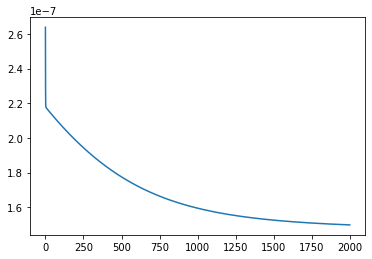

In [2]:
from opentn.transformations import create_kitaev_liouvillians, exp_operator_dt, factorize_psd, super2choi
d, N = 2, 4
dim = d**N
Lvec, Lvec_odd, Lvec_even, Lnn = create_kitaev_liouvillians(N=N, d=d, gamma=1e-2)
tau = 4
superops_exp = []
for i, op in enumerate([Lvec, Lvec_odd, Lvec_even]):
    if i == 1:
        superops_exp.append(exp_operator_dt(op, tau/2, 'jax'))
    else:
        superops_exp.append(exp_operator_dt(op, tau, 'jax'))
exp_Lvec, exp_Lvec_odd, exp_Lvec_even = superops_exp

X1 = factorize_psd(psd=super2choi(exp_Lvec_odd), tol=1e-12)
X2 = factorize_psd(psd=super2choi(exp_Lvec_even), tol=1e-12)

from opentn.optimization import gds, frobenius_norm, model_Ys, compute_loss
cost_n4, grads_n4, xi_n4 = gds(fn=compute_loss, x0=[X1, X2, X1], iter=int(2e3), loss_fn=frobenius_norm, model=model_Ys, rate=1.5e-9, exact = exp_Lvec, show_cost=False)
print(cost_n4[0])
print(cost_n4[-1])

plt.plot(cost_n4)

In [4]:
from opentn.transformations import super2choi, choi_composition, partial_transpose
from opentn.optimization import small2zero
from scipy import sparse

# rest of matrices optimized with GSD
X1_gds, X2_gds, X3_gds = xi_n4[-1]
Y2 = X2_gds@X2_gds.conj().T
Y3 = X3_gds@X3_gds.conj().T

# rhs to which we want to approximate
rhs = np.asarray(super2choi(superop=exp_Lvec, dim=dim))
srhs = sparse.csr_matrix(small2zero(rhs, tol=1e-10)) # small2zero was deleted
srhs = srhs.astype(np.float64)

# change partial transpose to A
A = choi_composition(C1=Y2, C2=Y3, dim=dim) # small2zero was deleted
A_tb = partial_transpose(A, dims=[dim, dim], idx=1)
I = np.eye(dim)
A_tbxI = np.kron(A_tb, I)
sA_tbxI = sparse.csr_matrix(small2zero(A_tbxI, tol=1e-10))
sA_tbxI = sA_tbxI.astype(np.float64)
sA_tbxI

/Users/emiliano_gr/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/scipy/sparse/_data.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
  self._deduped_data().astype(dtype, casting=casting, copy=copy),


<4096x4096 sparse matrix of type '<class 'numpy.float64'>'
	with 59136 stored elements in Compressed Sparse Row format>

In [5]:
X_initial = small2zero(X1_gds@X1_gds.conj().T, tol=1e-10).astype(np.float64)

/var/folders/_n/xw2mchz92t9_fcbxg7lwsdwh0000gn/T/ipykernel_9060/877660185.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  X_initial = small2zero(X1_gds@X1_gds.conj().T, tol=1e-10).astype(np.float64)


In [6]:
X = cp.Variable((dim**2,dim**2), PSD=True)
lhs =  cp.partial_trace(sA_tbxI @ cp.kron(I, X), dims=[dim, dim, dim], axis=1)
cost = cp.norm(lhs - srhs, "fro")
prob = cp.Problem(cp.Minimize(cost))
X.value = X_initial
print(cp.installed_solvers())

['COPT', 'ECOS', 'ECOS_BB', 'MOSEK', 'OSQP', 'SCIPY', 'SCS']


In [42]:
print(cp.installed_solvers())

['CLARABEL', 'COPT', 'ECOS', 'ECOS_BB', 'MOSEK', 'OSQP', 'SCIPY', 'SCS']


In [40]:
prob.solve(solver=cp.COPT, verbose=True, canon_backend=cp.SCIPY_CANON_BACKEND, sdpmethod=0)

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Jul 26 10:53:41 PM: Your problem has 65536 variables, 0 constraints, and 0 parameters.
(CVXPY) Jul 26 10:53:41 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 26 10:53:41 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 26 10:53:41 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 26 10:53:41 PM: Using cached ASA map, for faster compilation (bypassing reduction chain).


(CVXPY) Jul 26 10:53:41 PM: Finished problem compilation (took 3.017e-02 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Jul 26 10:53:41 PM: Invoking solver COPT  to obtain a solution.
Cardinal Optimizer v6.5.6. Build date Jul 21 2023
Copyright Cardinal Operations 2023. All Rights Reserved

Setting parameter 'Logging' to 1
Setting parameter 'SDPMethod' to 0
Model fingerprint: fa62bce8

Using Cardinal Optimizer v6.5.6 on macOS
Hardware has 8 cores and 8 threads. Using instruction set X86_SSE4_2 (8)
Maximizing an SDP problem

The original problem has:
    1 rows, 65537 columns and 1 non-zero elements
    1 PSD columns
    32896 PSD constraints
    1 cones

Using Primal-Dual Method

Starting barrier solver using 8 threads

Problem info:
Range of matrix coefficients:    [1e-10,1e+00]

1.009988692473399e-07

In [90]:
# we need to check that the cost function created through cvxpy is the same as with compute_loss, model_Ys, frobenius_norm**2
def cost_cvxpy(C1, C2, rhs, dim):
    I = np.eye(dim)
    C2_tb = partial_transpose(C2, dims=[dim, dim], idx=1)
    C2_tbxI = np.kron(C2_tb, I)
    C2_tbxI = sparse.csr_matrix(C2_tbxI)
    C2_tbxI = C2_tbxI.astype(np.float64)

    srhs = sparse.csr_matrix(rhs) # small2zero was deleted
    srhs = srhs.astype(np.float64)

    lhs =  cp.partial_trace(C2_tbxI @ cp.kron(I, C1), dims=[dim, dim, dim], axis=1)
    cost = cp.norm(lhs - srhs, "fro")
    return cost.value 

# cost_cvxpy(X.value, A, rhs, dim) # it gives the same result but we just have to add the small2zero thing
# would it help not adding the small2zero thing? 

In [228]:
from opentn.transformations import choi2super
X1opt = xi_n4[-1][0]
print(frobenius_norm(choi_composition(X1opt@X1opt.conj().T, A), rhs))
print(cost_cvxpy(X1opt@X1opt.conj().T, A, rhs, dim))
# check if the cost function would be the same if we used superoperators instead of choi matrices.
# this includes not using sparse matrices
print(frobenius_norm(choi2super(A)@choi2super(X1opt@X1opt.conj().T), exp_Lvec))

2.0762417533163998e-07


/Users/emiliano_gr/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/scipy/sparse/_data.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
  self._deduped_data().astype(dtype, casting=casting, copy=copy),


2.0762417532526505e-07
2.0762417533163993e-07


In [32]:
# now we do the same calculations but with the optimal value obtained from cvxpy
print(frobenius_norm(choi_composition(X.value, small2zero(A, tol=1e-10)), small2zero(rhs, tol=1e-10))) # value when small2zero was used on A and rhs: 2.6522855638959974e-07
# print(cost_cvxpy(X.value, A, rhs, dim))
# similar to above, we use only the superoperators
# print(frobenius_norm(choi2super(A)@choi2super(X.value), exp_Lvec))

# for this value with SCS solver we took:
# total: 4.72e+00s = setup: 1.89e+00s + solve: 2.82e+00s

1.0099886923168144e-07


In [33]:
cost.value

1.009988692473399e-07

In [34]:
print((X.value))

[[ 1.00000000e+00  2.63796069e-22 -4.00789192e-23 ...  3.76104212e-22
  -4.55776761e-22  1.00000000e+00]
 [ 2.63796069e-22  3.38818752e-09 -1.39443011e-24 ...  3.38839902e-24
  -1.38674207e-24  5.08505730e-22]
 [-4.00789192e-23 -1.39443011e-24  3.38818752e-09 ...  1.98373581e-25
  -1.84855450e-24 -1.44670471e-22]
 ...
 [ 3.76104212e-22  3.38839902e-24  1.98373581e-25 ...  3.38818752e-09
  -2.34393177e-24  5.35316316e-22]
 [-4.55776761e-22 -1.38674207e-24 -1.84855450e-24 ... -2.34393177e-24
   3.38818752e-09 -6.10268046e-22]
 [ 1.00000000e+00  5.08505730e-22 -1.44670471e-22 ...  5.35316316e-22
  -6.10268046e-22  1.00000000e+00]]


In [230]:
print(rhs.dtype)
print(X.value.dtype)

complex128
float64


In [44]:
np.linalg.matrix_rank(X.value, tol=1e-8)

12

In [110]:
np.linalg.matrix_rank(X1opt)

4

In [236]:
# checking if the matrices we obtained are actually purely real:
# (OLD): if any(x == True for x in np.iscomplex(rhs).flatten())
for op in [X2, X3, Y2, Y3, X1opt, rhs, A]:
    print(np.linalg.norm(op.imag.flatten()))

0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [35]:
max_idx = 32
print(np.sort(np.linalg.svd(X1@X1.conj().T, compute_uv=False))[::-1][:max_idx])
print('----')
print(np.sort(np.linalg.svd(X1_gds@X1_gds.conj().T, compute_uv=False))[::-1][:max_idx])
print('----')
print(np.sort(np.linalg.svd(X.value, compute_uv=False))[::-1][:max_idx])


[1.59601247e+01 1.99252079e-02 1.99252079e-02 2.48753638e-05
 9.41937007e-15 7.29470571e-15 6.84506863e-15 6.23095436e-15
 5.80100493e-15 5.78248737e-15 5.17804655e-15 4.94692450e-15
 4.85247368e-15 4.52496695e-15 4.42685077e-15 3.89746967e-15
 3.66693312e-15 3.60964684e-15 3.36566309e-15 2.87946771e-15
 2.78382111e-15 2.62033766e-15 2.41774270e-15 2.39242594e-15
 1.91779956e-15 1.89715199e-15 1.72563994e-15 1.68728462e-15
 1.61919989e-15 1.54653686e-15 1.39933466e-15 1.28447716e-15]
----
[1.59601248e+01 1.99251812e-02 1.99251787e-02 2.48753821e-05
 1.17915016e-14 9.08213709e-15 8.69352780e-15 8.37946884e-15
 7.66574976e-15 7.52920133e-15 7.01107572e-15 6.59208080e-15
 6.23536754e-15 5.20704729e-15 5.09354029e-15 4.78303898e-15
 4.69580713e-15 4.06464210e-15 3.94270522e-15 3.85177708e-15
 3.78104053e-15 3.50871149e-15 3.49006992e-15 2.88239594e-15
 2.80762888e-15 2.66169047e-15 2.52806861e-15 2.08363936e-15
 2.01836208e-15 1.76882084e-15 1.64575579e-15 1.56411260e-15]
----
[1.59601247e

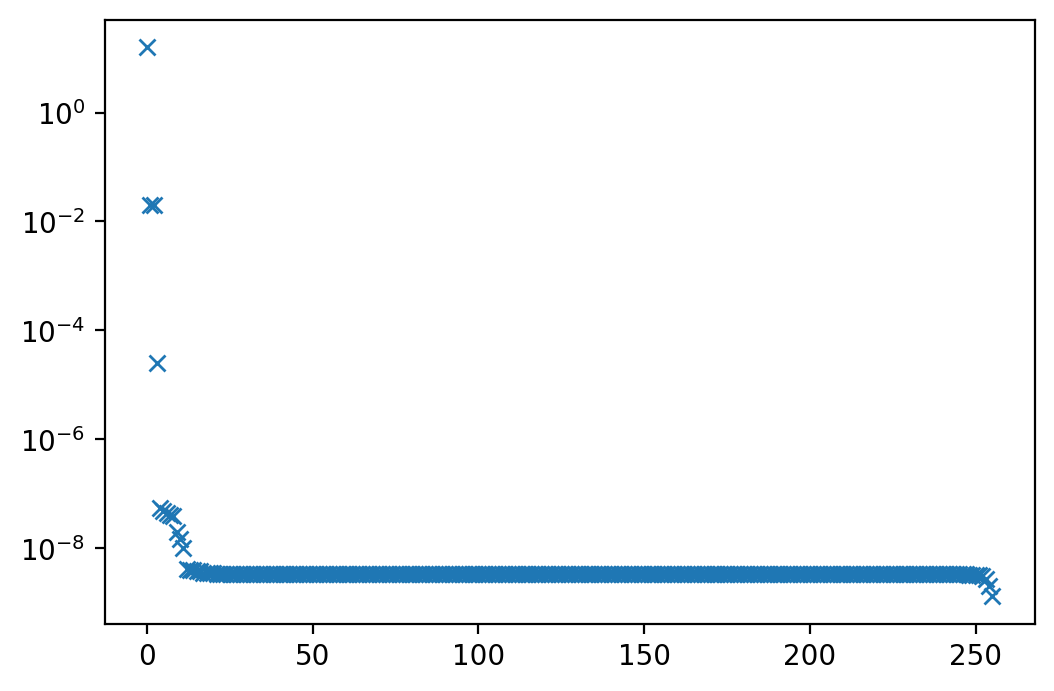

In [38]:
plt.figure(dpi=200)
plt.semilogy(np.linalg.svd(X.value, compute_uv=False), 'x')

In [39]:
with open('x_copt_dual.npy' ,'wb') as f:
    np.save(f, X.value)

# 24th July:
IDEA: is the configuration of the solver not good enough??
NOTE from workcomputer: random matrices (real and sparse) where taking 
- SCS: 235 min
- MOSEK: 289 min

NOTE: to install CXOPT, do so thorugh conda forge. pip produces an error.
I first tried building from source and that did not work either.

- Idea: use warm start from GDS: https://www.cvxpy.org/tutorial/advanced/index.html#warm-start. By setting the value of X to X1@X1.conj().T

- get standard form from cvxpy and solve it somewhere else: https://www.cvxpy.org/tutorial/advanced/index.html#getting-the-standard-form

- interesting one regarding using different solvers and plot results: https://www.cvxpy.org/examples/applications/l1_trend_filter.html

- defaults options for SCS: https://github.com/cvxpy/cvxpy/blob/02ce7a7014bc20cb9e87ecb6f7e39b8d08eb7f85/cvxpy/reductions/solvers/conic_solvers/scs_conif.py#L77

- idea on saving output of verbose (hacking source): https://stackoverflow.com/questions/75069030/mosek-via-cvxpy-save-verbose-output

NOTES FROM OPTIMIZATION:
- I did a warm start using GDS with 2e3 iterations.
- first optimization was using standard eps, had a value between initial and gds (closer to initial-> non optimized)
- second optimization with eps=1e-9, ran for 18 seconds becuse the problem was already compiled so it just had to call the solver. This gave result on the order of e-8!
- the singular values were reduced from 22 to 12 now!! (when using a tolerance of 1e-9)
- running third optimization now with e-11 to see if it helps even more. Taking longer already 